In [187]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import acr
import spikeinterface.extractors as se
import spikeinterface.core as si
import kdephys.units as ku
import pandas as pd
import numpy as np
import acr.info_pipeline as aip
import tdt
import acr.units as au
import matplotlib.pyplot as plt
plt.style.use('acr_plots.mplstyle')
import xarray as xr
import kdephys.xr as kx
import kdephys.hypno as kh

In [152]:
@pd.api.extensions.register_dataframe_accessor("un")
class SpikeAccessor:
    def __init__(self, pandas_obj):
        self._obj = pandas_obj

    def rec(self, rec):
        return self._obj.loc[self._obj.recording==rec]

    def stim(self):
        return self._obj.loc[self._obj.stim==1]
    
    def st(self, state):
        return self._obj.loc[self._obj.state==state]
    
    def ts(self, t1, t2):
        return self._obj.loc[np.logical_and(self._obj.datetime>t1, self._obj.datetime<t2)]

/tmp/ipykernel_1001298/3597034348.py:2: UserWarning: registration of accessor <class '__main__.SpikeAccessor'> under name 'un' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  class SpikeAccessor:


In [150]:
fp = acr.io.load_xr('ACR_14', ['sdpi-bl', 'sdpi', 'sdpi-post', 'laser1-bl', 'laser1', 'laser1-post1', 'swi-bl', 'swi-sd', 'swi'])

In [151]:
spg = kx.spectral.get_spg_from_dataset(fp)

In [153]:
bp = kx.spectral.get_bp_from_dataset(spg)

In [115]:
hyp = {}
hyp['sdpi'] = acr.io.load_hypno('ACR_14', 'sdpi')
hyp['sdpi-bl'] = acr.io.load_hypno('ACR_14', 'sdpi-bl')
hyp['laser1'] = acr.io.load_hypno('ACR_14', 'laser1')
hyp['laser1-bl'] = acr.io.load_hypno('ACR_14', 'laser1-bl')
hyp['swi'] = acr.io.load_hypno('ACR_14', 'swi')
hyp['swi-bl'] = acr.io.load_hypno('ACR_14', 'swi-bl')


In [2]:
df = au.single_probe_spike_df('ACR_14', 'sdpi-NNXr')
dfo = au.single_probe_spike_df('ACR_14', 'sdpi-NNXo')

/home/kdriessen/github_t2/acr/acr/units.py:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  states = pd.Series()


In [9]:
hyp['sdpi'].duration.sum()

Timedelta('0 days 11:59:59.941406254')

In [7]:
hyp['sdpi'].fractional_occupancy()['Wake']*hyp['sdpi'].duration.sum()

Timedelta('0 days 06:30:40.061532974')

Text(0.0, 1.0, 'SDPI Firing Rate, 60s Rolling Window')

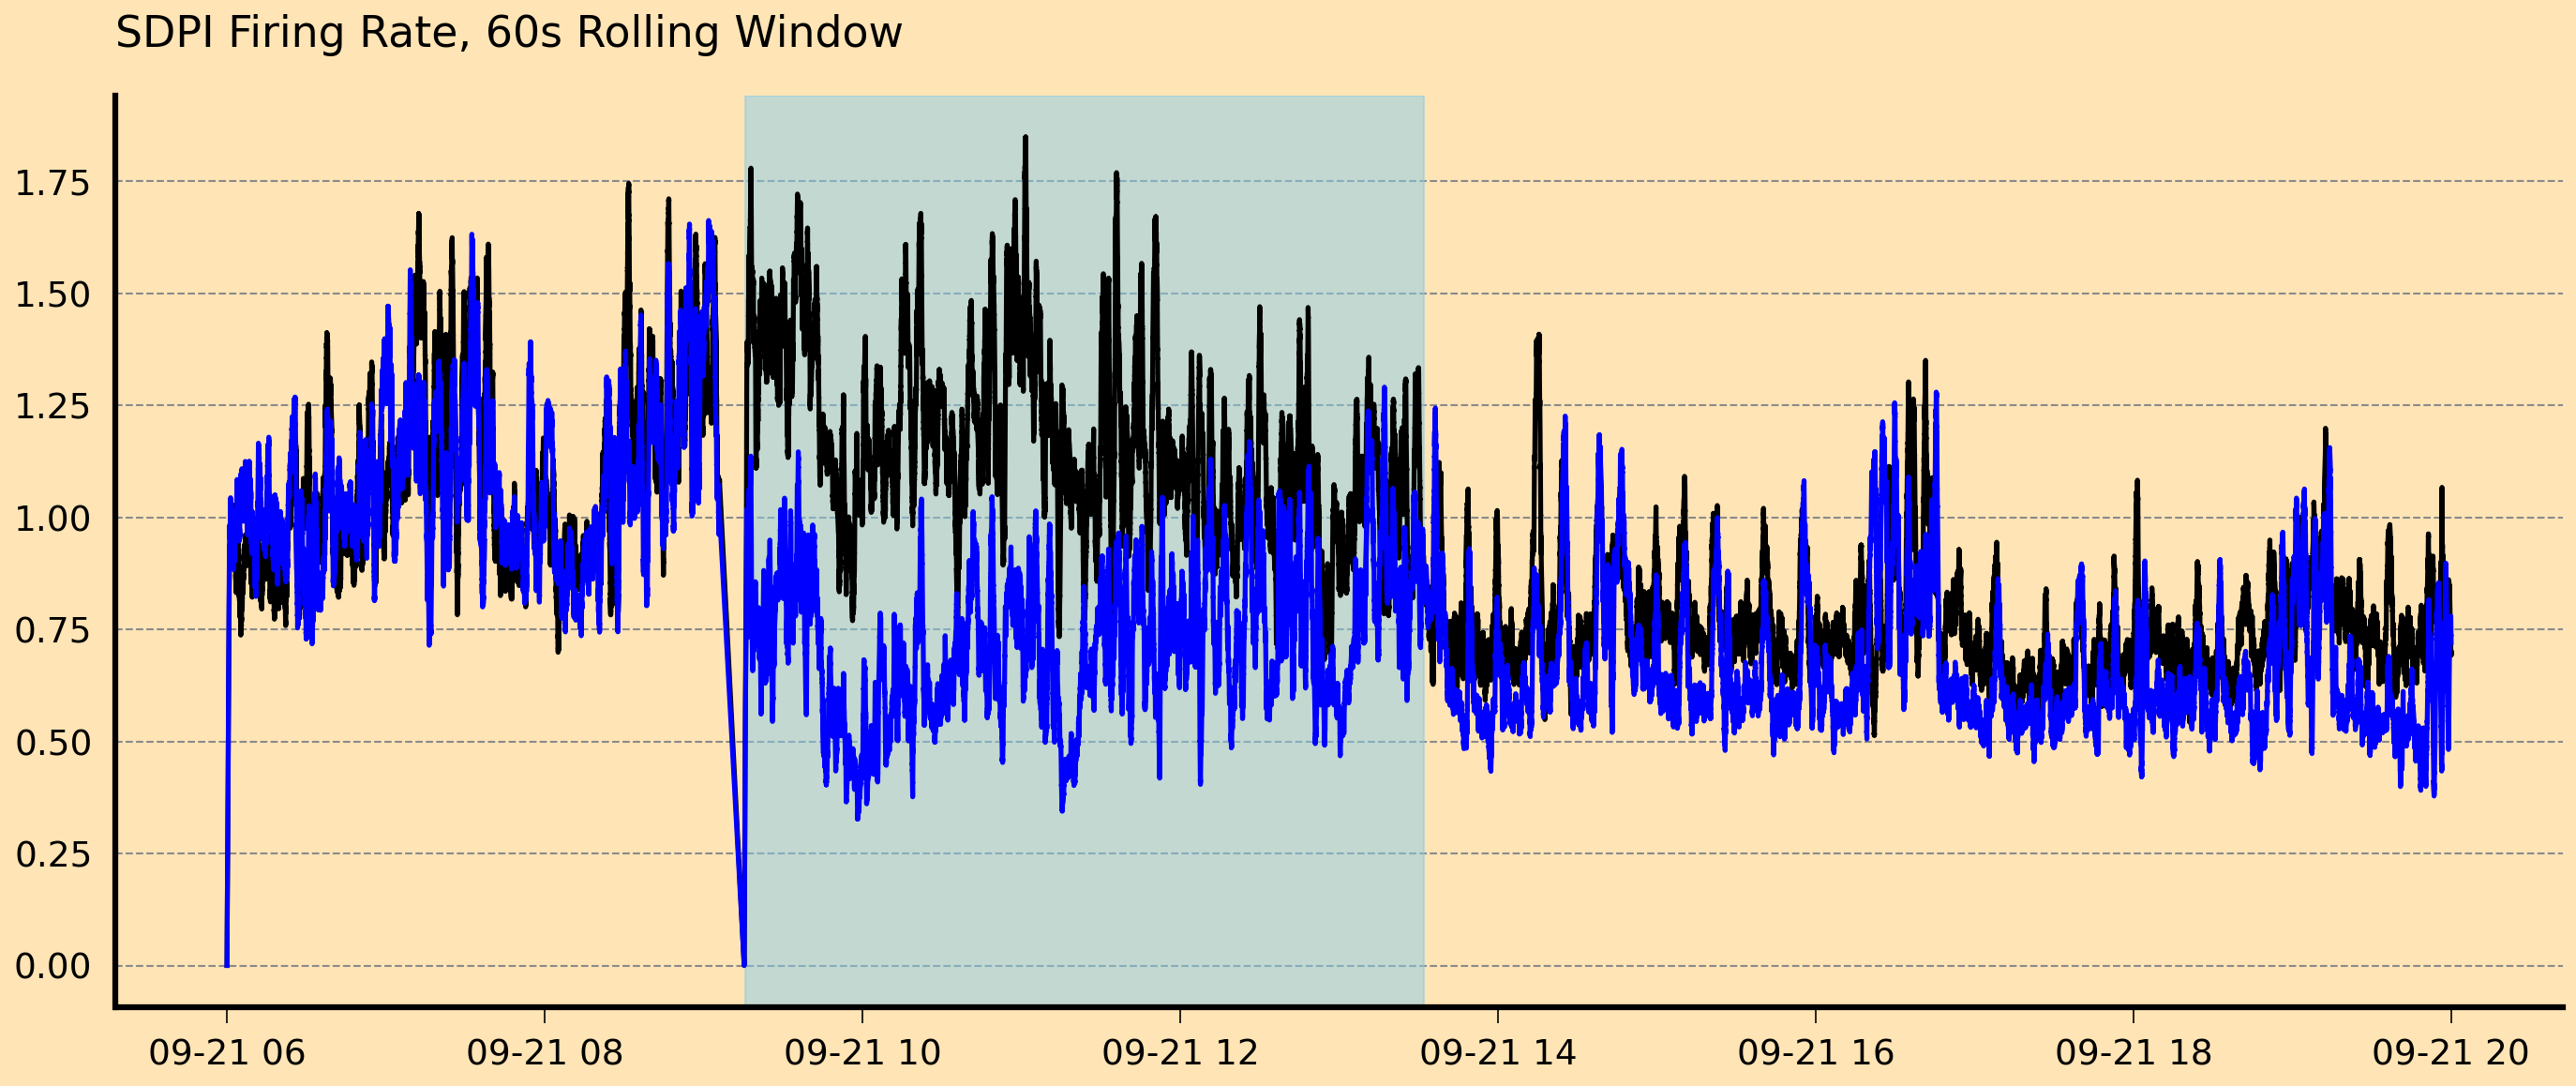

In [169]:
pm = df.s.rec('sdpi-bl').rolling('60s', on='datetime').count().cluster_id.values.mean()
om = dfo.s.rec('sdpi-bl').rolling('60s', on='datetime').count().cluster_id.values.mean()
t1 = '2022-09-21 6:00:00'
t2 = '2022-09-21 20:00:00'
pdata = df.un.ts(t1, t2).rolling('60s', on='datetime').count().cluster_id.values/pm
odata = dfo.un.ts(t1, t2).rolling('60s', on='datetime').count().cluster_id.values/om
f, ax = plt.subplots(1, 1, figsize=(20, 8))
ax.plot(df.un.ts(t1, t2).datetime.values, pdata, color='k')
ax.plot(dfo.un.ts(t1, t2).datetime.values, odata, color='blue')
stim_borders = df.un.stim().datetime.values.min(), df.un.stim().datetime.values.max()
ax.axvspan(stim_borders[0], stim_borders[1], color='skyblue', alpha=0.5)
ax.set_title('SDPI Firing Rate, 60s Rolling Window')

In [156]:
def xcat(ds, recordings, stores=['NNXo', 'NNXr']):
    data = {}
    for store in stores:
        to_concat = []
        for recording in recordings:
            to_concat.append(ds[f'{recording}-{store}'])
        data[store] = xr.concat(to_concat, dim='datetime')
    return data

In [157]:
sdpi = xcat(bp, ['sdpi-bl', 'sdpi', 'sdpi-post'])

(0.0, 1000000.0)

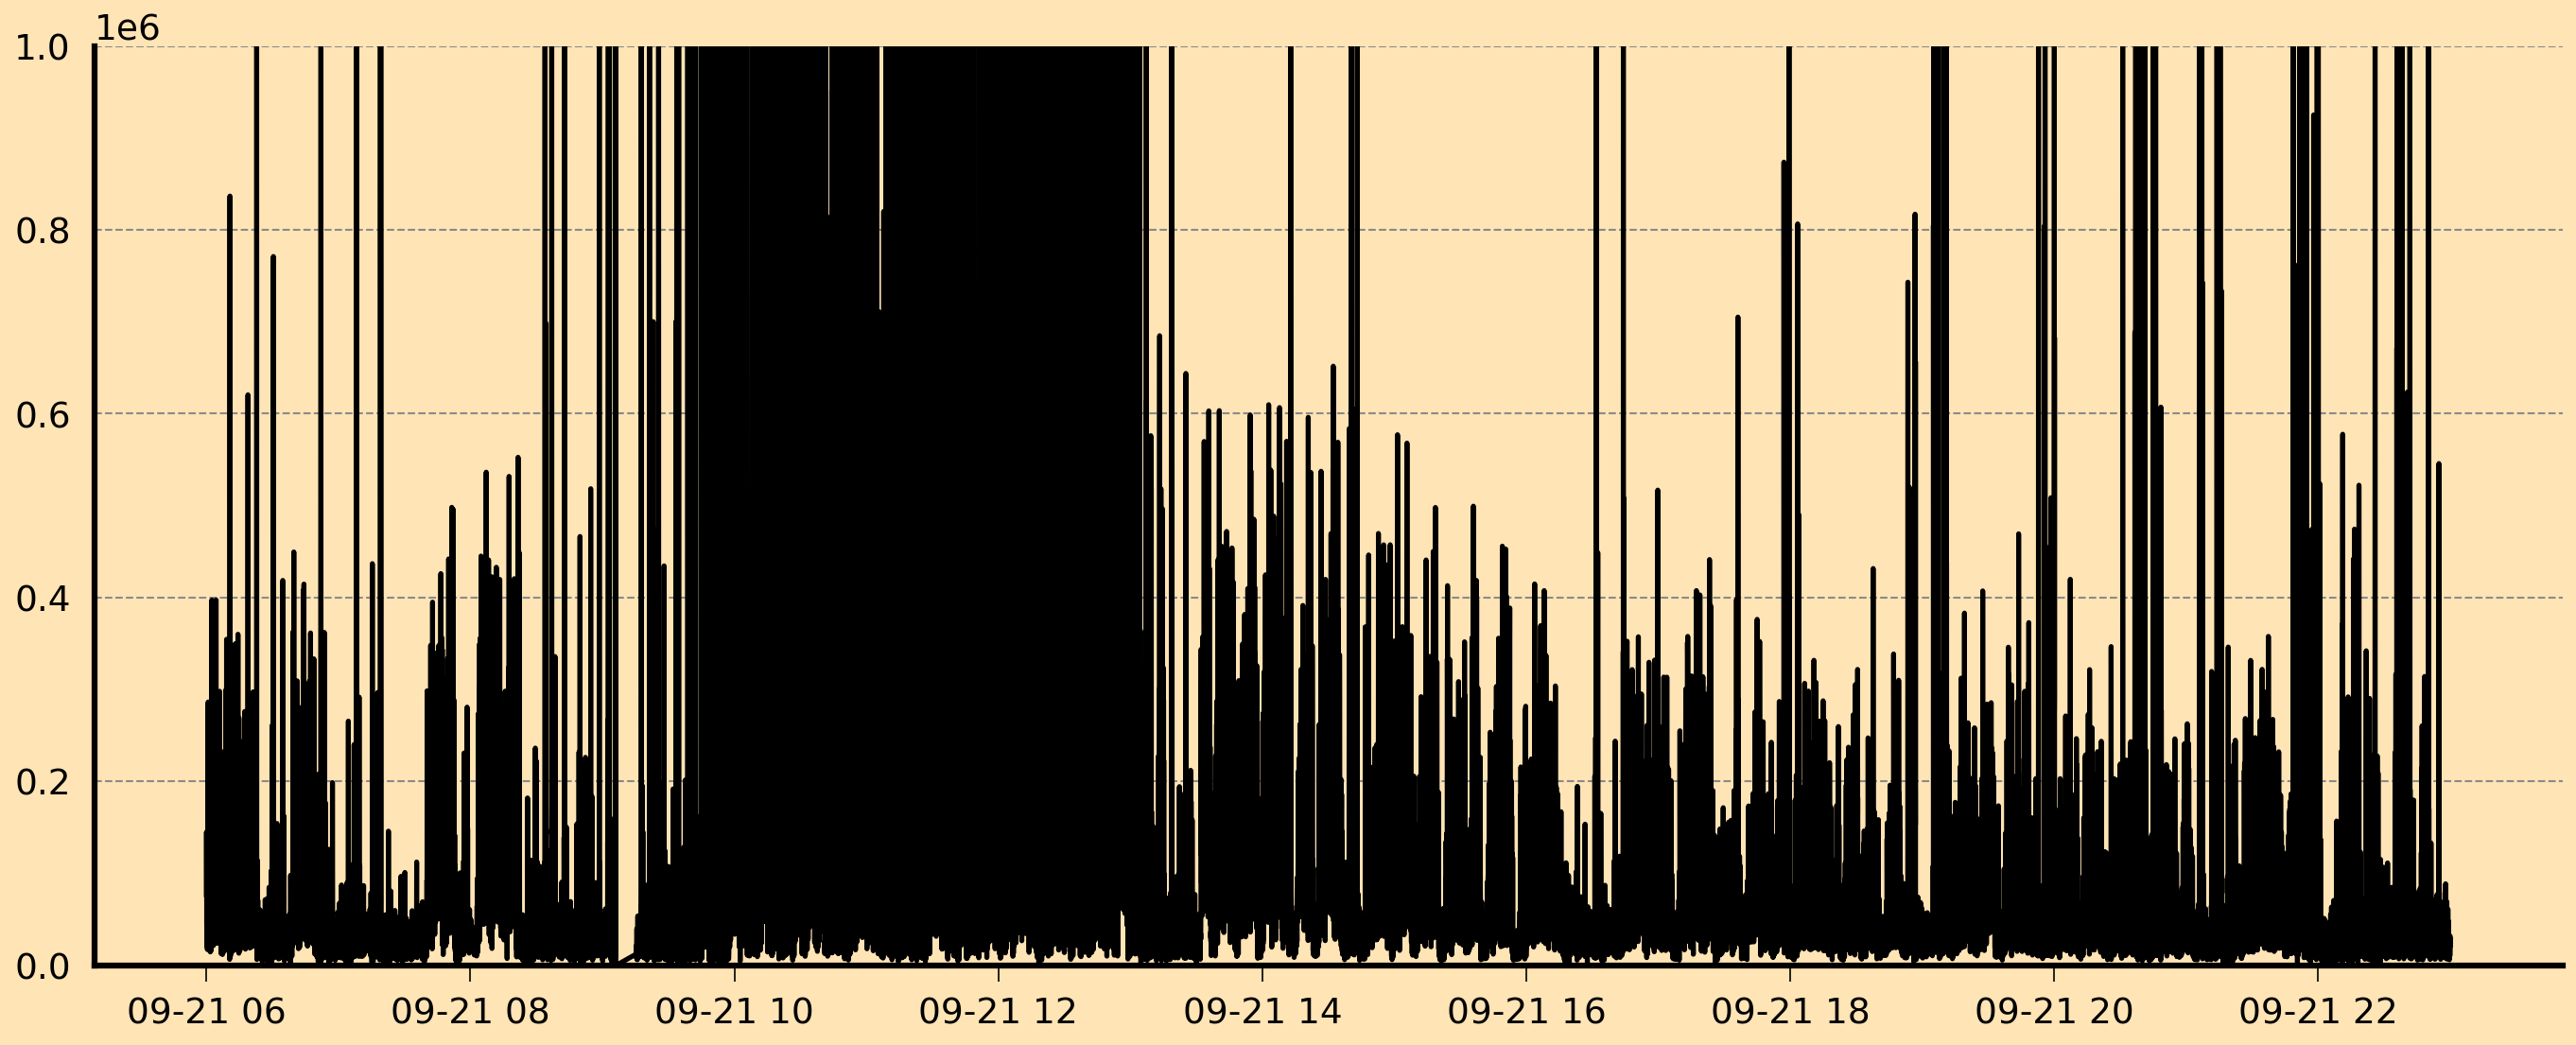

In [163]:
f, ax = plt.subplots(1, 1, figsize=(20, 8))
t1 = '2022-09-21 6:00:00'
t2 = '2022-09-21 23:00:00'
ts = slice(t1, t2)
ax.plot(sdpi['NNXr'].delta.sel(datetime=ts).datetime.values, sdpi['NNXr'].delta.sel(datetime=ts, channel=15), color='k')
ax.set_ylim(0, 1000000)

In [177]:
sdpi['NNXo'].datetime.sel(datetime=ts)

<xarray.DataArray 'datetime' (datetime: 30349)>
array(['2022-09-21T06:00:00.582271000', '2022-09-21T06:00:02.581119000',
       '2022-09-21T06:00:04.579967000', ..., '2022-09-21T22:59:55.485695000',
       '2022-09-21T22:59:57.484543000', '2022-09-21T22:59:59.483391000'],
      dtype='datetime64[ns]')
Coordinates:
    time       (datetime) float64 7.533e+04 7.534e+04 ... 4.948e+04 4.948e+04
    timedelta  (datetime) timedelta64[ns] 20:55:34.582272 ... 13:44:39.483392
  * datetime   (datetime) datetime64[ns] 2022-09-21T06:00:00.582271 ... 2022-...

# SWI - 'Slow Wave Induction'

In [119]:
d = {}
d['swio'] = au.single_probe_spike_df('ACR_14', 'swi-NNXo')
d['swip'] = au.single_probe_spike_df('ACR_14', 'swi-NNXr')

/home/kdriessen/github_t2/acr/acr/units.py:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  states = pd.Series()
/home/kdriessen/github_t2/acr/acr/units.py:96: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  states = pd.Series()


In [135]:
swi.keys()

dict_keys(['swi-bl-NNXo', 'swi-bl-NNXr', 'swi-sd-NNXo', 'swi-sd-NNXr', 'swi-NNXo', 'swi-NNXr'])

In [166]:
d['swip'].un.stim()

,time,cluster_id,group,note,sort_id,recording,datetime,stim,state
7944567,104372.263565,50,mua,gw/frmod_state,swi-NNXr,swi,2022-10-07 14:06:51.922691907,1.0,Wake
7944568,104372.263728,191,mua,gw/merged,swi-NNXr,swi,2022-10-07 14:06:51.922855747,1.0,Wake
7944569,104372.263933,199,mua,noisy/art,swi-NNXr,swi,2022-10-07 14:06:51.923060547,1.0,Wake
7944570,104372.265203,195,mua,merged,swi-NNXr,swi,2022-10-07 14:06:51.924330307,1.0,Wake
7944571,104372.266104,58,mua,NaN,swi-NNXr,swi,2022-10-07 14:06:51.925231428,1.0,Wake
...,...,...,...,...,...,...,...,...,...
8101646,106223.774251,193,mua,merged/art/noisy,swi-NNXr,swi,2022-10-07 14:37:43.433378782,1.0,Wake
8101647,106223.778388,193,mua,merged/art/noisy,swi-NNXr,swi,2022-10-07 14:37:43.437515742,1.0,Wake
8101648,106223.808617,185,mua,merged,swi-NNXr,swi,2022-10-07 14:37:43.467744225,1.0,Wake
8101655,106224.219323,185,mua,merged,swi-NNXr,swi,2022-10-07 14:37:43.878450188,1.0,Wake


In [171]:
d['swio'].un.stim()

,time,cluster_id,group,note,sort_id,recording,datetime,stim,state
13221761,104372.258240,9,mua,NaN,swi-NNXo,swi,2022-10-07 14:06:51.918964547,1.0,Wake
13221762,104372.259264,110,mua,bw/merged,swi-NNXo,swi,2022-10-07 14:06:51.919988547,1.0,Wake
13221763,104372.259919,107,mua,bw/merged,swi-NNXo,swi,2022-10-07 14:06:51.920643907,1.0,Wake
13221764,104372.261107,38,mua,frmod,swi-NNXo,swi,2022-10-07 14:06:51.921831747,1.0,Wake
13221765,104372.261844,0,mua,frmod_rec,swi-NNXo,swi,2022-10-07 14:06:51.922569027,1.0,Wake
...,...,...,...,...,...,...,...,...,...
13394459,106223.359654,107,mua,bw/merged,swi-NNXo,swi,2022-10-07 14:37:43.020379060,1.0,Wake
13394460,106223.361948,108,mua,merged/gw,swi-NNXo,swi,2022-10-07 14:37:43.022672820,1.0,Wake
13394461,106223.372352,108,mua,merged/gw,swi-NNXo,swi,2022-10-07 14:37:43.033076661,1.0,Wake
13394462,106223.372843,113,mua,frmod_rec/bw,swi-NNXo,swi,2022-10-07 14:37:43.033568181,1.0,Wake


Text(0.0, 1.0, 'swi Firing Rate, 60s Rolling Window')

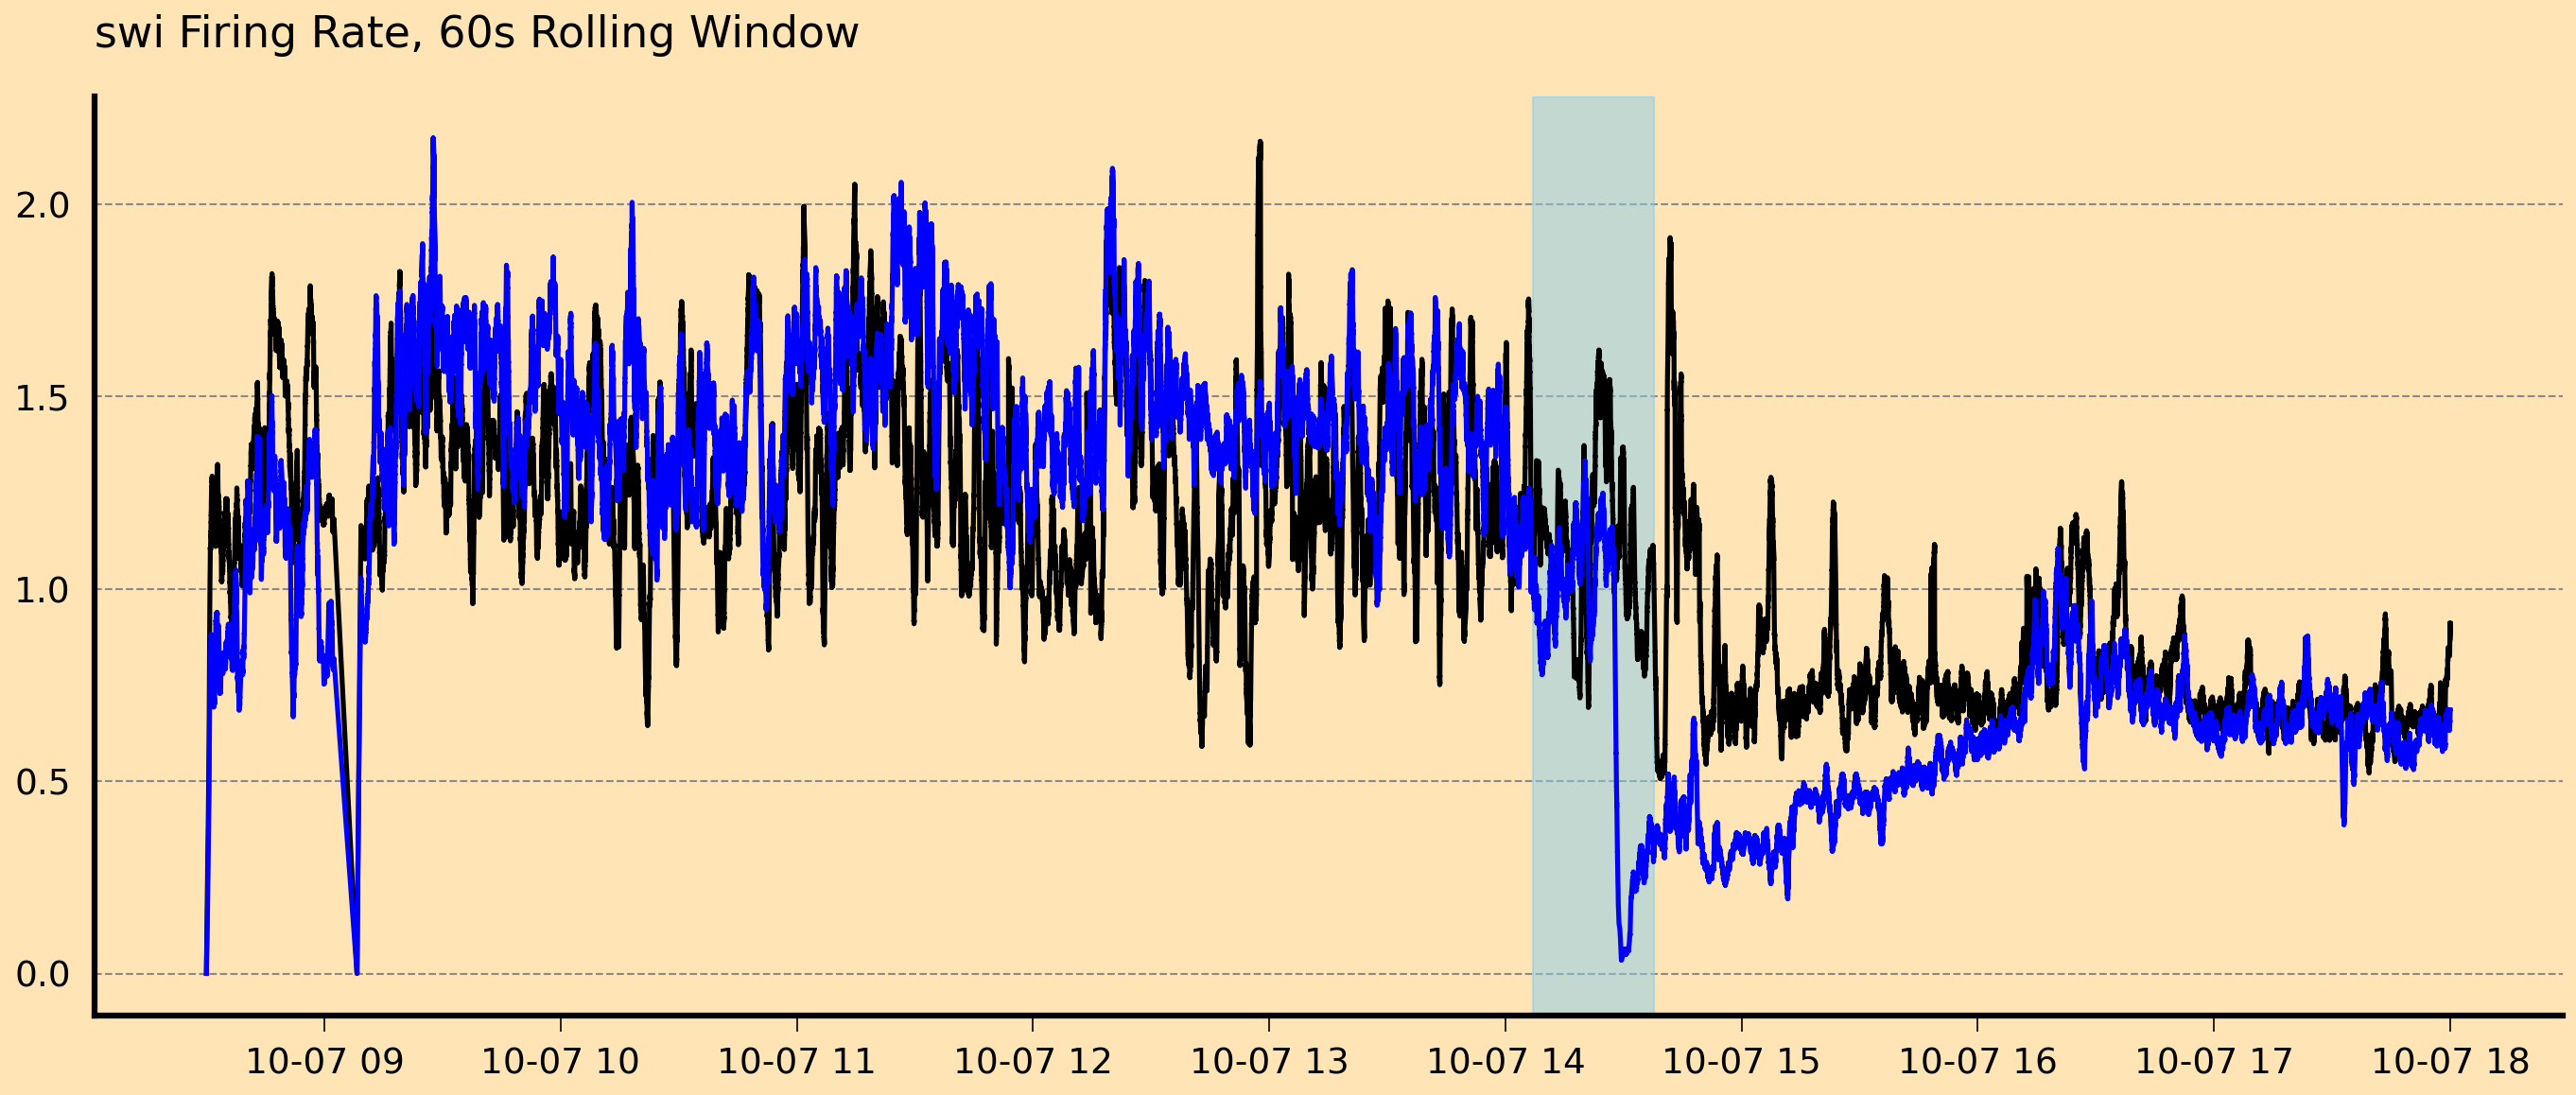

In [178]:
pm = d['swip'].un.rec('swi-bl').rolling('60s', on='datetime').count().cluster_id.values.mean()
om = d['swio'].un.rec('swi-bl').rolling('60s', on='datetime').count().cluster_id.values.mean()
t1 = '2022-10-07 08:30:00'
t2 = '2022-10-07 18:00:00'
pdata = d['swip'].un.ts(t1, t2).rolling('60s', on='datetime').count().cluster_id.values/pm
odata = d['swio'].un.ts(t1, t2).rolling('60s', on='datetime').count().cluster_id.values/om
f, ax = plt.subplots(1, 1, figsize=(20, 8))
ax.plot(d['swip'].un.ts(t1, t2).datetime.values, pdata, color='k')
ax.plot(d['swio'].un.ts(t1, t2).datetime.values, odata, color='blue')
stim_borders = d['swio'].un.stim().datetime.values.min(), d['swio'].un.stim().datetime.values.max()
ax.axvspan(stim_borders[0], stim_borders[1], color='skyblue', alpha=0.5)
ax.set_title('swi Firing Rate, 60s Rolling Window')

In [179]:
swi = xcat(bp, ['swi-bl', 'swi-sd', 'swi'])

In [184]:
bp['swi-bl-NNXo']

<xarray.DataArray 'delta' ()>
array(72721.14, dtype=float32)

In [190]:
blo = kh.add_states(bp['swi-bl-NNXo'], hyp['swi-bl'],)
blp = kh.add_states(bp['swi-bl-NNXr'], hyp['swi-bl'])
om = blo.where(blo.state=='NREM', drop=True).delta.mean(dim='datetime')
pm = blp.where(blp.state=='NREM', drop=True).delta.mean(dim='datetime')

In [218]:
swi_rel = {}
swi_rel['NNXo'] = kx.utils.get_smoothed_ds(swi['NNXo']/om)
swi_rel['NNXr'] = kx.utils.get_smoothed_ds(swi['NNXr']/pm)

In [ ]:
kx.utils.g

(0.0, 7.0)

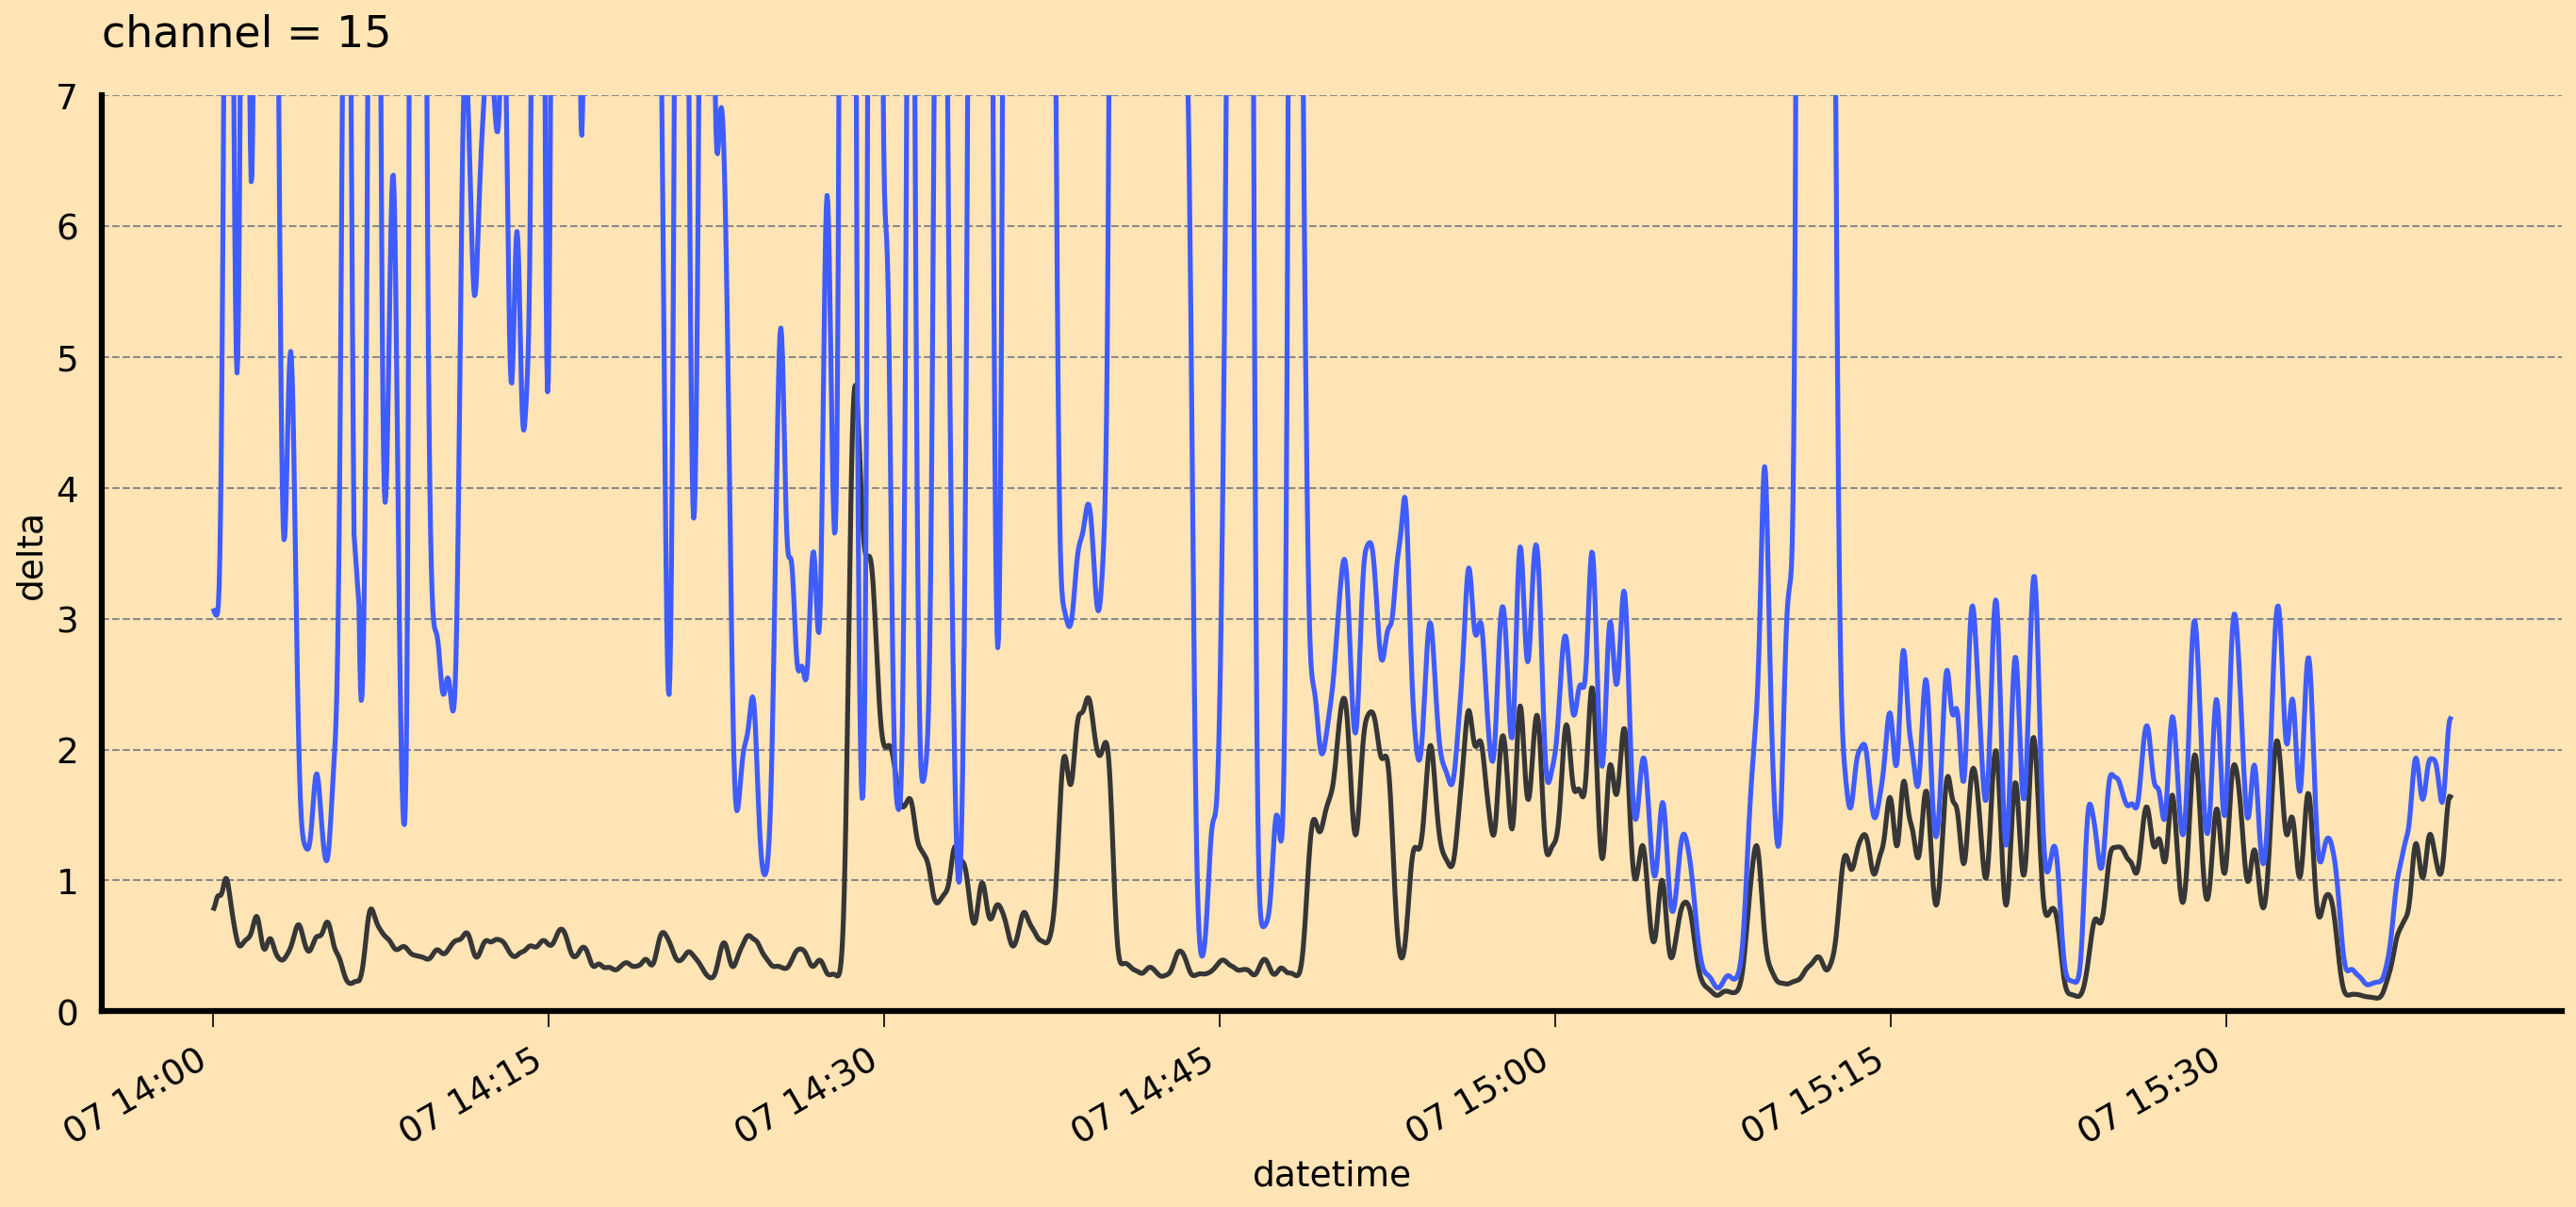

In [221]:
t1 = '2022-10-07 14:00:00'
t2 = '2022-10-07 15:40:00'
f, ax = plt.subplots(1, 1, figsize=(20, 8))
swi_rel['NNXo'].delta.sel(datetime = slice(t1, t2), channel=15).plot(ax=ax)
swi_rel['NNXr'].delta.sel(datetime = slice(t1, t2), channel=15).plot(ax=ax)
ax.set_ylim(0, 7)

# Double-SD (laser1)